In [ ]:
# %pip install kagglehub  pandas numpy matplotlib seaborn scikit-learn
# %pip install scipy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import pandas as pd

cycles = pd.read_csv('datasets/cycleData.csv', sep='\t')
cycles.head()

,start_date,end_date,session_time,cycleId
0,2024-11-10 00:16:38.935688,2024-11-10 00:28:02.174248,683.238560,437.0
1,2024-11-10 00:28:02.174248,2024-11-10 00:39:25.654009,683.479761,438.0
2,2024-11-10 00:39:25.654009,2024-11-10 00:50:49.066924,683.412915,439.0
3,2024-11-10 00:50:49.066924,2024-11-10 01:02:12.432060,683.365136,440.0
4,2024-11-10 01:02:12.432060,2024-11-10 01:13:35.821410,683.389350,441.0


In [7]:
# # Extract date and times
# df_cycles = pd.DataFrame({
#     'date': pd.to_datetime(cycles['start_date']).dt.date,
#     'start_time': pd.to_datetime(cycles['start_date']).dt.time,
#     'end_time': pd.to_datetime(cycles['end_date']).dt.time,
#     'end_date': pd.to_datetime(cycles['end_date']).dt.date
# })

# # Group by date and get first start time and last end time
# daily_summary = df_cycles.groupby('date').agg({
#     'start_time': 'min',
#     'end_time': 'max'
# }).reset_index()

# daily_summary.head()

In [8]:
import pandas as pd

nodes = pd.read_csv('datasets/data.csv', sep='\t')

# add date to nodes
nodes['date'] = pd.to_datetime(nodes['time'], format='%y-%m-%dT%H:%M:%S.%f').dt.strftime('%Y-%m-%d')

nodes.head()

,time,X-axis,Y-axis,date
0,24-11-10T00:00:00.000000,791.074,187.620,2024-11-10
1,24-11-10T00:00:15.000000,699.262,180.747,2024-11-10
2,24-11-10T00:00:30.000000,732.582,179.469,2024-11-10
3,24-11-10T00:00:45.000000,974.761,171.136,2024-11-10
4,24-11-10T00:01:00.000000,969.228,175.637,2024-11-10


['2024-11-10' '2024-11-11']

2024-11-10 data shape: (5760, 4)
--------------------------------------------------
2024-11-10 average X-axis: 869.80
2024-11-10 25th percentile X-axis: 466.04
2024-11-10 75th percentile X-axis: 940.42
2024-11-10 standard deviation X-axis: 725.28
2024-11-10 outliers: 119

2024-11-11 data shape: (716, 4)
--------------------------------------------------
2024-11-11 average X-axis: 888.11
2024-11-11 25th percentile X-axis: 457.95
2024-11-11 75th percentile X-axis: 970.50
2024-11-11 standard deviation X-axis: 714.53
2024-11-11 outliers: 16


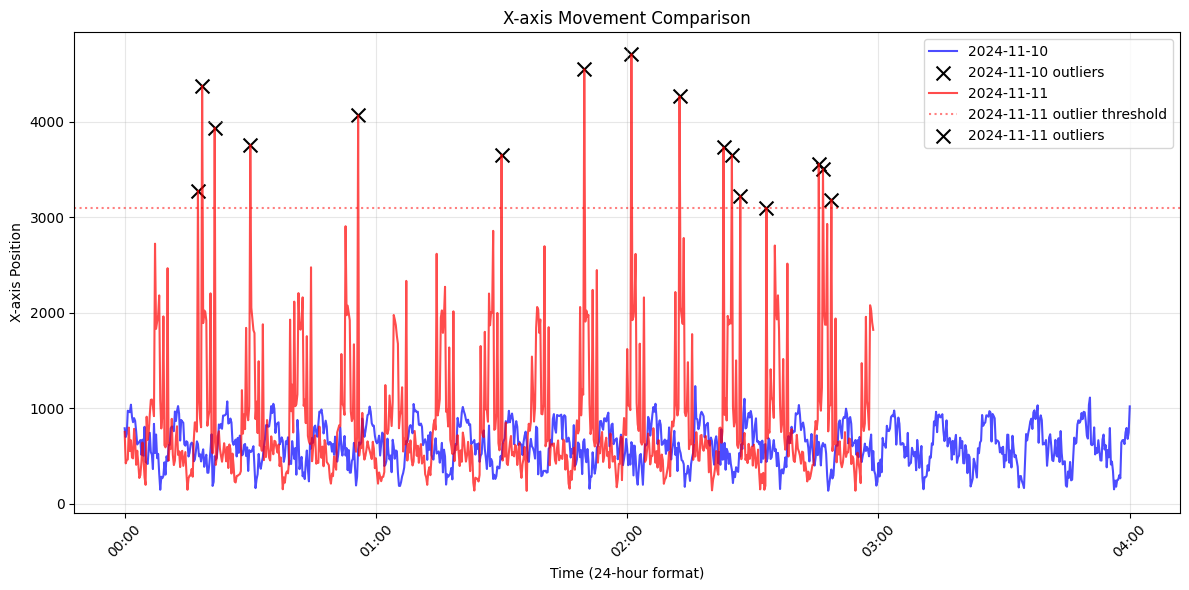

In [47]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# convert time to seconds
def time_to_seconds(time):
    h, m, s = map(int, time.split(':'))
    return h * 3600 + m * 60 + s

# Convert seconds to time format for better readability
def seconds_to_time(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    return f"{int(hours):02d}:{int(minutes):02d}"

def plot_data_for_dates(data, dates, property_name, start_time=None, end_time=None, colors=None):
    if colors is None:
        colors = ['b', 'r', 'g', 'c', 'm', 'y', 'k']  # Default colors for up to 7 days
    
    if len(dates) > 7:
        raise ValueError("Can only compare up to 7 days")
    
    plt.figure(figsize=(12, 6))
    
    plot_mean = []
    for i, date in enumerate(dates):
        day_data = data[data['date'] == date].copy()
        print(f'\n{date} data shape: {day_data.shape}')

        # mean of the property
        mean_value = day_data[property_name].mean()
        plot_mean.append(mean_value)
        print("-" * 50)
        print(f'{date} average {property_name}: {mean_value:.2f}')

        # percentiles
        p25 = day_data[property_name].quantile(0.25)
        p75 = day_data[property_name].quantile(0.75)
        print(f'{date} 25th percentile {property_name}: {p25:.2f}')
        print(f'{date} 75th percentile {property_name}: {p75:.2f}')

        # plot a dotter line for the mean value
        # plt.axhline(y=mean_value, color=f'{colors[i]}', linestyle='--', alpha=0.3, label=f'{date} mean')
        # plt.axhline(y=p25, color=f'{colors[i]}', linestyle='--', alpha=0.3, label=f'{date} 25th percentile')
        # plt.axhline(y=p75, color=f'{colors[i]}', linestyle='--', alpha=0.3, label=f'{date} 75th percentile')

        # Standard deviation
        std = day_data[property_name].std()
        print(f'{date} standard deviation {property_name}: {std:.2f}')

        # Z-score
        z_score = (day_data[property_name] - mean_value) / std
        # Calculate outliers
        outliers = day_data[z_score.abs() > 3]
        print(f'{date} outliers: {outliers.shape[0]}')
        
        # Convert time to seconds once for day_data
        day_data['seconds'] = day_data['time'].apply(lambda x: time_to_seconds(x.split('T')[1].split('.')[0]))
        
        # Filter by time range if specified
        if start_time and end_time:
            start_seconds = time_to_seconds(start_time)
            end_seconds = time_to_seconds(end_time)
            mask = (day_data['seconds'] >= start_seconds) & (day_data['seconds'] <= end_seconds)
            day_data = day_data[mask]

        # Plot main data
        plt.plot(day_data['seconds'], day_data[property_name], f'{colors[i]}-', 
            label=f'{date}', alpha=0.7)
            
        # Plot outliers within time range
        if len(outliers) > 0:
            outliers['seconds'] = outliers['time'].apply(lambda x: time_to_seconds(x.split('T')[1].split('.')[0]))
            if start_time and end_time:
                outliers = outliers[(outliers['seconds'] >= start_seconds) & (outliers['seconds'] <= end_seconds)]
            
            if len(outliers) > 0:
                # Calculate minimum outlier value
                min_outlier = outliers[property_name].min()
                # Draw horizontal dotted line at minimum outlier value
                plt.axhline(y=min_outlier, color=colors[i], linestyle=':', 
                    alpha=0.5, label=f'{date} outlier threshold')
            
            plt.scatter(outliers['seconds'], outliers[property_name], 
                  c='black', marker='x', s=100, 
                  label=f'{date} outliers')

    plt.title(f'{property_name} Movement Comparison')
    plt.xlabel('Time (24-hour format)')
    plt.ylabel(f'{property_name} Position')
    
    # Set x-axis ticks to show hours based on time range
    start_hour = int(start_time.split(':')[0]) if start_time else 0
    end_hour = int(end_time.split(':')[0]) if end_time else 24
    hours_to_show = np.arange(start_hour * 3600, (end_hour + 1) * 3600, 3600)
    plt.xticks(hours_to_show, [seconds_to_time(h) for h in hours_to_show], rotation=45)
    
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

dates_to_compare = nodes['date'].unique()
print(dates_to_compare)
plot_data_for_dates(nodes, dates_to_compare, 'X-axis', 
                    start_time='00:00:00', end_time='04:00:00')